In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.svm import SVC

In [4]:
df_over_1 = pd.read_csv("feaSubEOvert_1.csv", names = range(120))
df_over_2 = pd.read_csv("feaSubEOvert_2.csv", names = range(120))

df_img_1 = pd.read_csv("feaSubEImg_1.csv", names = range(120))
df_img_2 = pd.read_csv("feaSubEImg_2.csv", names = range(120))

df_BCI = pd.read_csv("BCIsensor_xy.csv", names = ["x", "y"])

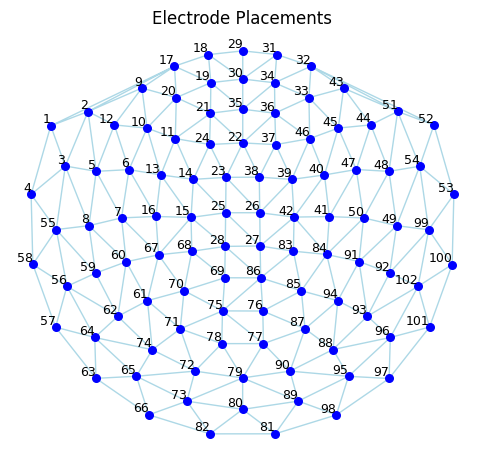

In [84]:
import matplotlib.tri as mtri
def plot_electrode_layout(df, annotate_indices=None, point_size=30):
    xs = df['x'].values
    ys = df['y'].values
    
    # Build a triangulation to connect nearest neighbors
    triang = mtri.Triangulation(xs, ys)
    
    # Plot
    fig, ax = plt.subplots(figsize=(6,6))
    ax.triplot(triang, color='lightblue', linewidth=1)
    ax.scatter(xs, ys, color='blue', s=point_size, zorder=2)
    
    # Annotate specific channels, if given
    if annotate_indices:
        for idx in annotate_indices:
            ax.text(xs[idx], ys[idx], str(idx+1),
                    fontsize=9, color='black', 
                    verticalalignment='bottom',
                    horizontalalignment='right')
    
    ax.set_aspect('equal', 'box')
    ax.axis('off')
    ax.set_title("Electrode Placements")
    plt.show()

plot_electrode_layout(df_BCI, annotate_indices=range(102))

In [6]:
def convertToXY(df_class_1, df_class_2, trials = 120):
    X = []
    y = []
    for i in range(trials):
        X.append(np.array(df_class_1[i]))
        y.append(0)

        X.append(np.array(df_class_2[i]))
        y.append(1)
    
    X = np.array(X)
    y = np.array(y)

    return X, y

In [165]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def plot_svm_weight_topomap(model,
                            electrode_pos,
                            title,
                            grid_res=200,
                            point_size=20,           
                            circle_edgecolor='white',
                            circle_facecolor='none'):
    w = model.coef_.ravel()
    n_feat = w.size
    n_el   = len(electrode_pos)

    if n_feat == 2*n_el:
        w_el = np.sqrt(w[0::2]**2 + w[1::2]**2)
    

    xs = electrode_pos['x'].values
    ys = electrode_pos['y'].values

    xi = np.linspace(xs.min(), xs.max(), grid_res)
    yi = np.linspace(ys.min(), ys.max(), grid_res)
    Xi, Yi = np.meshgrid(xi, yi)

    Zi = griddata((xs, ys), w_el, (Xi, Yi), method='cubic')

    plt.figure(figsize=(6, 6))
    plt.pcolormesh(Xi, Yi, Zi, shading='auto', cmap='viridis')
    plt.scatter(xs, ys,
                s=point_size,
                edgecolors=circle_edgecolor,
                facecolors=circle_facecolor,
                linewidths=1.2)
    plt.gca().set_aspect('equal', 'box')
    plt.axis('off')

    pcm = plt.pcolormesh(Xi, Yi, Zi,
                         shading='auto',
                         cmap='viridis',
                         vmin=0,
                         vmax=w_el.max())

    cb = plt.colorbar(pcm, label='|weight|')
    cb.ax.tick_params(labelsize=10)

    plt.title(title, fontsize=14)   # added title
    plt.tight_layout()
    plt.show()

In [172]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

def plot_weight_stem_top6(model,
                          n_channels=204,
                          title="Signed SVM Weights Across Channels"):
    """
    Stem-plot the signed SVM “weights” for each channel, highlighting the top 6 in red.
    Works for both linear and non-linear kernels by using coef_ if available,
    or dual_coef_ @ support_vectors_ otherwise.
    """
    # 0) unwrap pipeline if needed
    if isinstance(model, Pipeline):
        # assume the final step is our SVC
        svc = model.named_steps.get('svc', model.steps[-1][1])
    else:
        svc = model

    # 1) extract or compute weight vector
    if hasattr(svc, 'coef_'):
        w = svc.coef_.ravel()
    else:
        # fallback: reconstruct w in input space
        # dual_coef_.shape = (1, n_SV) for binary
        dual = svc.dual_coef_.ravel()          # shape (n_SV,)
        sv   = svc.support_vectors_            # shape (n_SV, n_features)
        w    = np.dot(dual, sv)                # shape (n_features,)

    # 2) sanity check channel count
    if w.size != n_channels:
        raise ValueError(f"Expected {n_channels} features, but got {w.size}")

    # 3) pick top 6 by absolute magnitude
    abs_w = np.abs(w)
    top6_idx = np.argsort(abs_w)[-6:]
    top6_idx = top6_idx[np.argsort(abs_w[top6_idx])[::-1]]
    top6 = [(int(i), float(w[i])) for i in top6_idx]

    # 4) stem plot
    idxs = np.arange(n_channels)
    fig, ax = plt.subplots(figsize=(12, 4))
    markerline, stemlines, baseline = ax.stem(
        idxs, w, linefmt='-', markerfmt='o', basefmt='k-'
    )
    plt.setp(stemlines, color='tab:blue', linewidth=1)
    plt.setp(baseline, color='gray', linewidth=0.5)
    plt.setp(markerline, markersize=4, markeredgecolor='tab:blue', markerfacecolor='tab:blue')

    # 5) highlight top-6
    ax.scatter(top6_idx, w[top6_idx],
               s=60, c='red', marker='o', zorder=3, label='Top 6 |weights|')

    # 6) formatting
    ax.set_xlabel("Channel Index", fontsize=12)
    ax.set_ylabel("Weight Value", fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xticks(np.arange(0, n_channels, step=10))
    ax.grid(which='both', linestyle='--', alpha=0.4)
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    return top6


In [170]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.svm             import SVC
from sklearn.metrics         import roc_curve, auc, accuracy_score

# assume plot_svm_weight_topomap now supports non‐linear via permutation_importance:
# def plot_svm_weight_topomap(model, electrode_pos, title, X=None, y=None, ...):

def twoLevelCV_withROC(X, y,
                      kernel='linear',
                      alphas=[0.01, 1, 100, 10000],
                      gammas=[1e-3, 1e-2, 1e-1, 1, 10],
                      degrees=[2, 3, 4],
                      coef0s=[0, 1],
                      datatype='Overt'):
    outer_cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=0)
    all_y_true, all_y_score = [], []
    overall_corr, overall_tot = 0, 0

    plt.figure(figsize=(8, 6))
    for fold_idx, (tr_idx, te_idx) in enumerate(outer_cv.split(X, y), start=1):
        X_tr, y_tr = X[tr_idx], y[tr_idx]
        X_te, y_te = X[te_idx], y[te_idx]

        # build param grid
        if kernel == 'rbf':
            grid = [{'C': C, 'gamma': g} for C in alphas for g in gammas]
        elif kernel == 'poly':
            grid = [{'C': C, 'gamma': g, 'degree': d, 'coef0': c0}
                    for C in alphas
                    for d in degrees
                    for g in gammas
                    for c0 in coef0s]
        else:
            grid = [{'C': C} for C in alphas]

        # inner CV to pick best params
        best = {k: None for k in ('C','gamma','degree','coef0')}
        best['acc'] = -np.inf
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

        for params in grid:
            accs = []
            for i_tr, i_val in inner_cv.split(X_tr, y_tr):
                svc_kwargs = {'kernel': kernel,
                              'C': params['C'],
                              'probability': True}
                if kernel == 'rbf':
                    svc_kwargs['gamma'] = params['gamma']
                elif kernel == 'poly':
                    svc_kwargs.update({
                        'gamma':  params['gamma'],
                        'degree': params['degree'],
                        'coef0':  params['coef0']
                    })

                pipe = Pipeline([
                    ('scaler', StandardScaler()),
                    ('svc',    SVC(**svc_kwargs))
                ])
                pipe.fit(X_tr[i_tr], y_tr[i_tr])
                preds = pipe.predict(X_tr[i_val])
                accs.append(accuracy_score(y_tr[i_val], preds))

            mean_acc = np.mean(accs)
            if mean_acc > best['acc']:
                best.update(params)
                best['acc'] = mean_acc

        print(f"Fold {fold_idx} inner best → C={best['C']}"
              + (f", γ={best['gamma']}" if kernel!='linear' else "")
              + (f", degree={best['degree']}, coef0={best['coef0']}" if kernel=='poly' else "")
              + f" (acc={best['acc']:.3f})")

        # final pipeline on full train‐fold
        final_kwargs = {'kernel': kernel, 'C': best['C'], 'probability': True}
        if kernel == 'rbf':
            final_kwargs['gamma'] = best['gamma']
        elif kernel == 'poly':
            final_kwargs.update({
                'gamma':  best['gamma'],
                'degree': best['degree'],
                'coef0':  best['coef0']
            })

        final_pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('svc',    SVC(**final_kwargs))
        ])
        final_pipe.fit(X_tr, y_tr)

        if fold_idx == 1 and kernel == 'linear':
            plot_svm_weight_topomap(final_pipe['svc'], df_BCI, title = f"SVM weights for fold 1 - {datatype} ")
            top_6 = plot_weight_stem_top6(final_pipe['svc'])
            for i in range(6):
                print(f"Channel index {top_6[i][0]} with weight {top_6[i][1]}")

        # test‐fold ROC & accuracy
        probs = final_pipe.predict_proba(X_te)[:, 1]
        preds = final_pipe.predict(X_te)

        all_y_true .extend(y_te)
        all_y_score.extend(probs)

        fpr, tpr, _ = roc_curve(y_te, probs)
        fold_auc    = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label=f'Fold {fold_idx} (AUC={fold_auc:.2f})')

        corr = np.sum(preds == y_te)
        overall_corr += corr
        overall_tot  += len(y_te)
        print(f"Fold {fold_idx} test acc: {corr/len(y_te):.3f}")

    # overall ROC
    fpr_tot, tpr_tot, _ = roc_curve(all_y_true, all_y_score)
    auc_tot = auc(fpr_tot, tpr_tot)
    plt.plot(fpr_tot, tpr_tot, 'k-', lw=2, label=f'Total CV (AUC={auc_tot:.2f})')
    plt.plot([0, 1], [0, 1], 'k:', lw=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{datatype} Per-fold & Total CV ROC ({kernel} kernel)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    print(f"Overall CV accuracy: {overall_corr/overall_tot:.3f}")


In [151]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.svm             import SVC
from sklearn.metrics         import roc_curve, auc, accuracy_score

def cross_train(X_train, y_train, X_test, y_test, title,
                kernel='linear',
                alphas=[0.01, 1, 100, 10000],
                gammas=[1e-3, 1e-2, 1e-1, 1, 10],
                degrees=[2, 3, 4],
                coef0s=[0, 1]):
    """
    6-fold inner CV to pick best hyperparams (C, plus gamma for RBF, plus degree/coef0 for poly),
    with StandardScaler; train on all X_train; then evaluate on X_test and plot ROC.
    """
    # 1) build grid of (C, gamma, degree, coef0) tuples
    if kernel == 'rbf':
        grid = [(C, g, None, None) for C in alphas for g in gammas]
    elif kernel == 'poly':
        grid = [(C, g, d, c0)
                for C in alphas
                for d in degrees
                for g in gammas
                for c0 in coef0s]
    else:  # linear
        grid = [(C, None, None, None) for C in alphas]

    # 2) inner CV to pick best
    skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=0)
    best = {'C': None, 'gamma': None, 'degree': None, 'coef0': None, 'acc': -np.inf}

    for C, gamma, degree, coef0 in grid:
        correct, total = 0, 0
        for tr_i, val_i in skf.split(X_train, y_train):
            # build a pipeline scaling → SVC
            svc_kwargs = {'kernel': kernel, 'C': C, 'probability': True}
            if kernel == 'rbf':
                svc_kwargs['gamma'] = gamma
            elif kernel == 'poly':
                svc_kwargs.update({'gamma':  gamma,
                                   'degree': degree,
                                   'coef0':  coef0})

            pipe = Pipeline([
                ('scaler', StandardScaler()),
                ('svc',    SVC(**svc_kwargs))
            ])

            pipe.fit(X_train[tr_i], y_train[tr_i])
            preds = pipe.predict(X_train[val_i])
            correct += np.sum(preds == y_train[val_i])
            total   += len(preds)

        acc = correct / total
        if acc > best['acc']:
            best.update({'C': C, 'gamma': gamma,
                         'degree': degree, 'coef0': coef0,
                         'acc': acc})

    # report chosen hyperparams
    extra = ""
    if kernel == 'rbf':
        extra = f", γ={best['gamma']}"
    elif kernel == 'poly':
        extra = f", degree={best['degree']}, coef0={best['coef0']}"
    print(f"Best params → C={best['C']}{extra} (inner CV acc={best['acc']:.3f})")

    # 3) final train on all of X_train
    final_kwargs = {'kernel': kernel, 'C': best['C'], 'probability': True}
    if kernel == 'rbf':
        final_kwargs['gamma'] = best['gamma']
    elif kernel == 'poly':
        final_kwargs.update({'gamma':  best['gamma'],
                             'degree': best['degree'],
                             'coef0':  best['coef0']})

    final_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('svc',    SVC(**final_kwargs))
    ])
    final_pipe.fit(X_train, y_train)

    # 4) test-set accuracy
    preds = final_pipe.predict(X_test)
    acc   = accuracy_score(y_test, preds)
    print(f"Test accuracy: {acc:.3f}")

    # 5) ROC on X_test
    scores = final_pipe.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, scores)
    roc_auc     = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title} ROC ({kernel} kernel)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


In [10]:
X_img, y_img = convertToXY(df_img_1, df_img_2)
X_over, y_over = convertToXY(df_over_1, df_over_2)

<Figure size 800x600 with 0 Axes>

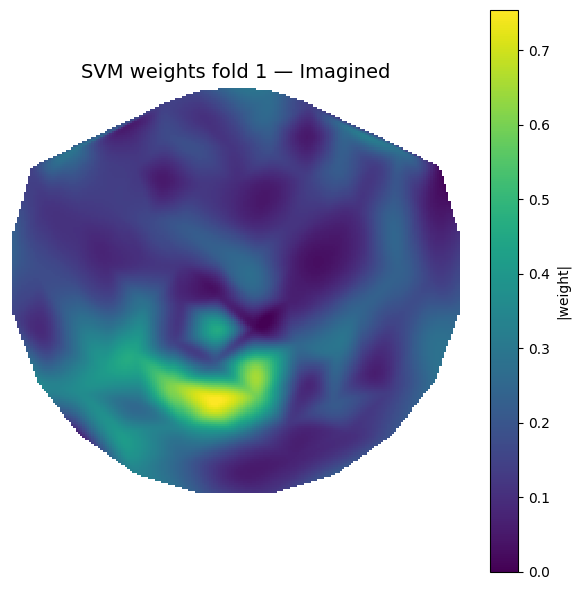

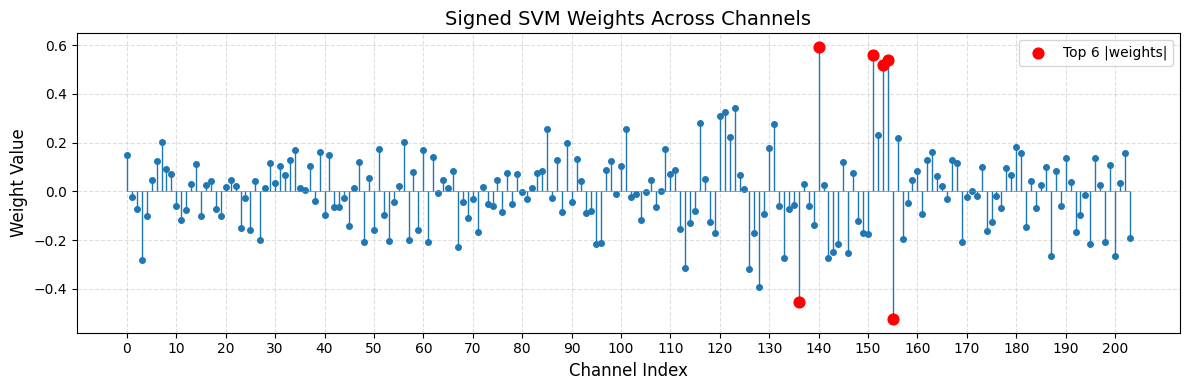

Channel 140 → weight 0.5933
Channel 151 → weight 0.5590
Channel 154 → weight 0.5411
Channel 155 → weight -0.5250
Channel 153 → weight 0.5179
Channel 136 → weight -0.4551
Fold 1 acc: 0.850 (C=1)
Fold 2 acc: 0.950 (C=0.01)
Fold 3 acc: 0.850 (C=1)
Fold 4 acc: 0.850 (C=0.01)
Fold 5 acc: 0.875 (C=1)
Fold 6 acc: 0.875 (C=1)


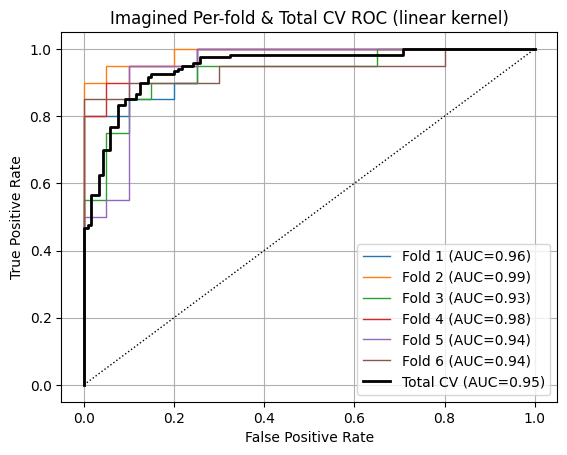

Overall CV accuracy: 0.875


In [134]:
twoLevelCV_withROC(X_img, y_img, datatype="Imagined") #scenario 2

Fold 1 inner best → C=1 (acc=0.965)


<Figure size 800x600 with 0 Axes>

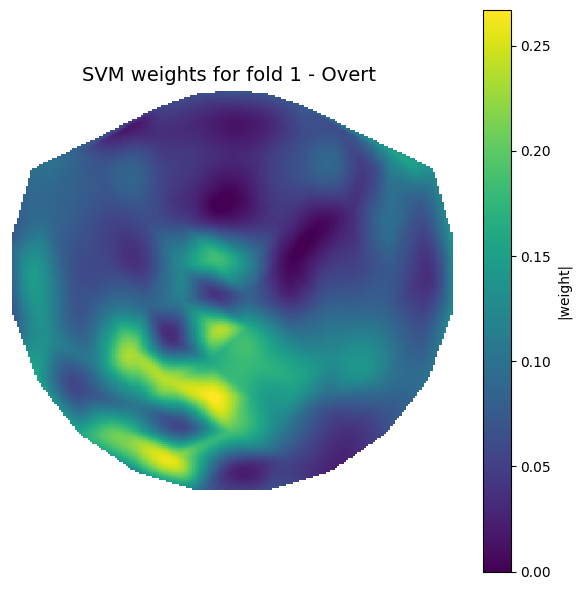

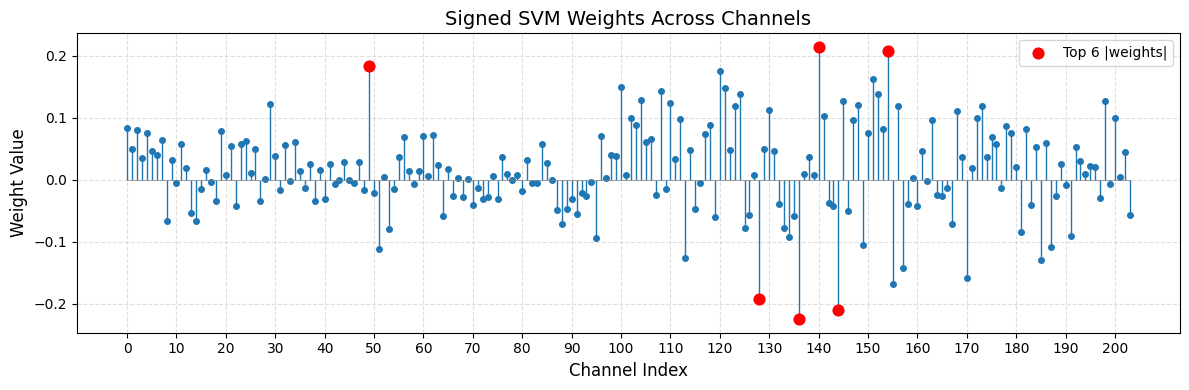

Channel index 136 with weight -0.22514551003380331
Channel index 140 with weight 0.21433611119868148
Channel index 144 with weight -0.21104607981524862
Channel index 154 with weight 0.2073716533688854
Channel index 128 with weight -0.19221245792808736
Channel index 49 with weight 0.18371008599719887
Fold 1 test acc: 0.975
Fold 2 inner best → C=1 (acc=0.960)
Fold 2 test acc: 0.950
Fold 3 inner best → C=1 (acc=0.965)
Fold 3 test acc: 0.975
Fold 4 inner best → C=1 (acc=0.960)
Fold 4 test acc: 0.975
Fold 5 inner best → C=0.01 (acc=0.955)
Fold 5 test acc: 0.950
Fold 6 inner best → C=1 (acc=0.980)
Fold 6 test acc: 0.950


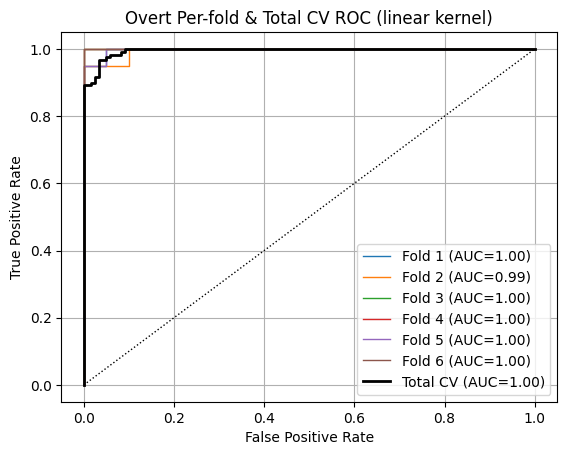

Overall CV accuracy: 0.963


In [173]:
twoLevelCV_withROC(X_over, y_over) #scenario 1

Best params → C=0.01 (inner acc=0.892)
Test accuracy: 0.938


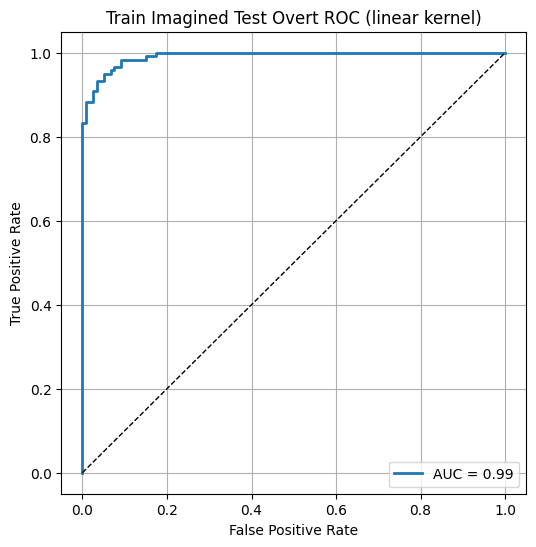

In [136]:
cross_train(X_img, y_img, X_over, y_over, title = "Train Imagined Test Overt") #scenario 4   

Best params → C=1 (inner acc=0.971)
Test accuracy: 0.892


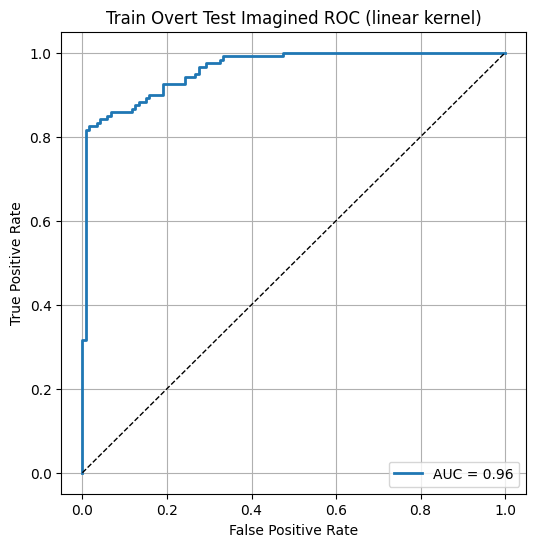

In [137]:
cross_train(X_over, y_over, X_img, y_img, title = "Train Overt Test Imagined") #scenario 3

Fold 1 inner best → C=100, γ=0.001 (acc=0.875)
Fold 1 test acc: 0.900
Fold 2 inner best → C=100, γ=0.001 (acc=0.890)
Fold 2 test acc: 0.900
Fold 3 inner best → C=100, γ=0.001 (acc=0.895)
Fold 3 test acc: 0.875
Fold 4 inner best → C=100, γ=0.001 (acc=0.880)
Fold 4 test acc: 0.950
Fold 5 inner best → C=100, γ=0.001 (acc=0.880)
Fold 5 test acc: 0.925
Fold 6 inner best → C=100, γ=0.001 (acc=0.875)
Fold 6 test acc: 0.875


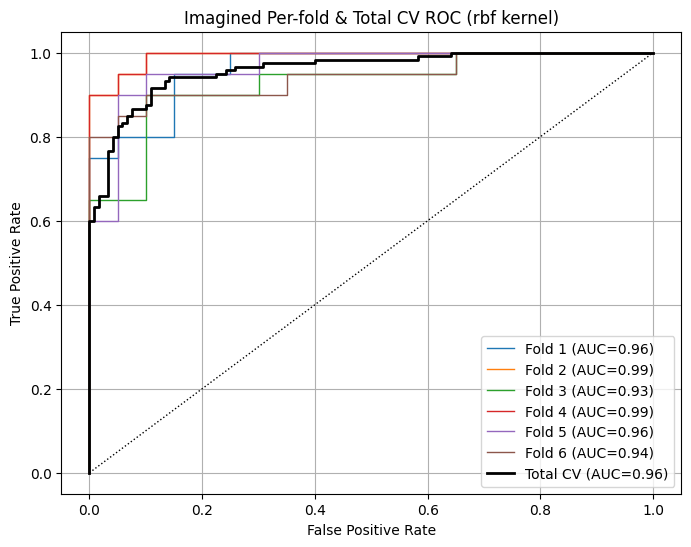

Overall CV accuracy: 0.904


In [167]:
twoLevelCV_withROC(X_img, y_img, kernel = 'rbf', datatype="Imagined") #scenario 2

Fold 1 inner best → C=100, γ=0.001 (acc=0.940)
Fold 1 test acc: 0.975
Fold 2 inner best → C=100, γ=0.01 (acc=0.945)
Fold 2 test acc: 0.875
Fold 3 inner best → C=100, γ=0.001 (acc=0.965)
Fold 3 test acc: 0.950
Fold 4 inner best → C=100, γ=0.001 (acc=0.970)
Fold 4 test acc: 1.000
Fold 5 inner best → C=100, γ=0.001 (acc=0.945)
Fold 5 test acc: 0.975
Fold 6 inner best → C=100, γ=0.001 (acc=0.950)
Fold 6 test acc: 0.950


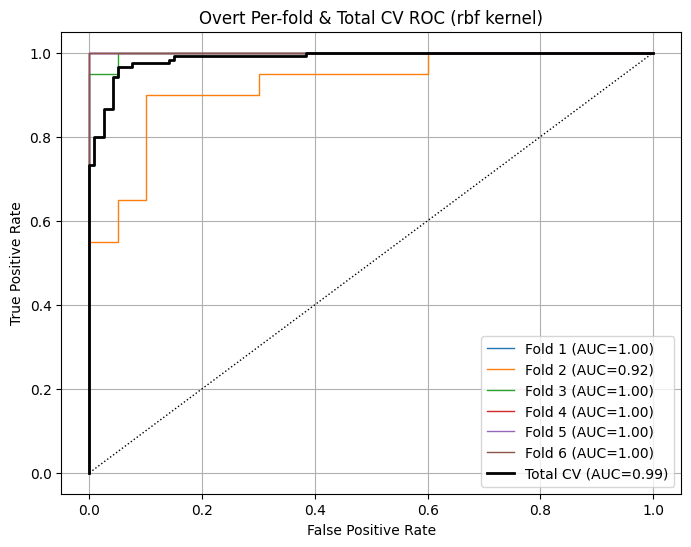

Overall CV accuracy: 0.954


In [168]:
twoLevelCV_withROC(X_over, y_over, kernel = 'rbf')

Best params → C=100, γ=0.001 (inner acc=0.904)
Test accuracy: 0.942


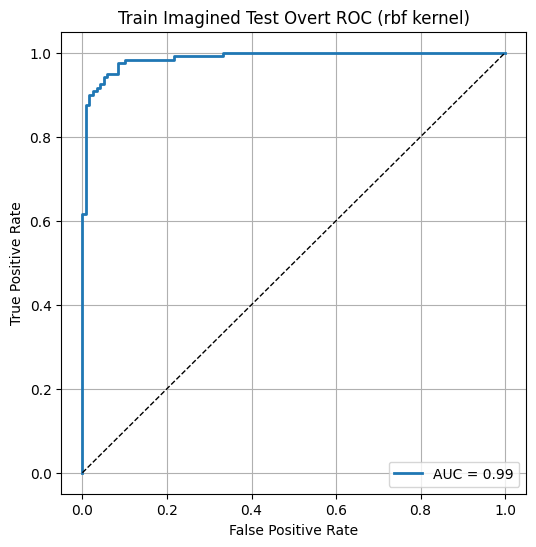

In [140]:
cross_train(X_img, y_img, X_over, y_over, kernel='rbf', title = "Train Imagined Test Overt") #scenario 4   

Best params → C=100, γ=0.001 (inner acc=0.958)
Test accuracy: 0.863


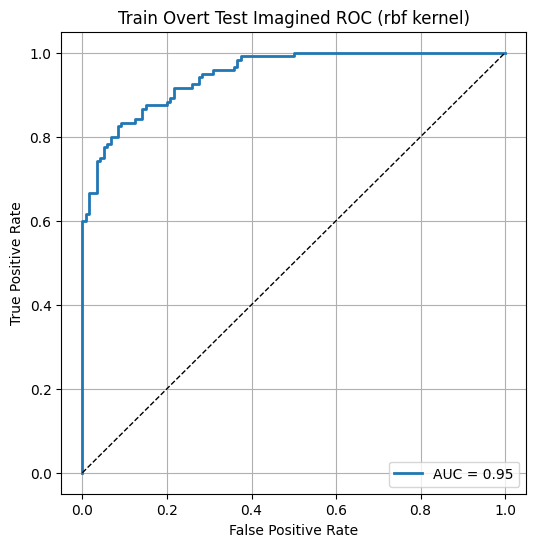

In [142]:
cross_train(X_over, y_over, X_img, y_img, kernel='rbf', title = "Train Overt Test Imagined") #scenario 4   

Fold 1 inner best → C=100, γ=0.001, degree=2, coef0=1 (acc=0.945)
Fold 1 test acc: 0.975
Fold 2 inner best → C=1, γ=0.001, degree=2, coef0=1 (acc=0.950)
Fold 2 test acc: 0.875
Fold 3 inner best → C=1, γ=0.01, degree=2, coef0=1 (acc=0.965)
Fold 3 test acc: 0.900
Fold 4 inner best → C=100, γ=0.001, degree=2, coef0=1 (acc=0.975)
Fold 4 test acc: 1.000
Fold 5 inner best → C=100, γ=0.001, degree=2, coef0=1 (acc=0.960)
Fold 5 test acc: 1.000
Fold 6 inner best → C=100, γ=0.001, degree=2, coef0=1 (acc=0.960)
Fold 6 test acc: 0.950


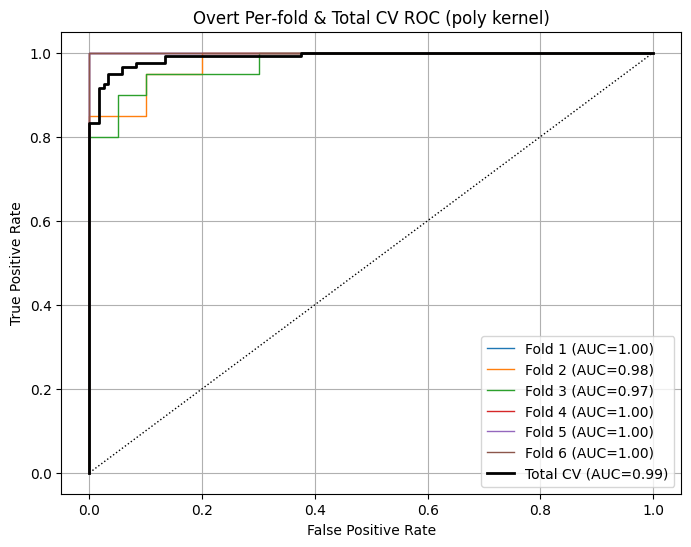

Overall CV accuracy: 0.950


In [149]:
twoLevelCV_withROC(X_over, y_over, kernel = 'poly')

Fold 1 inner best → C=1, γ=0.001, degree=4, coef0=1 (acc=0.885)
Fold 1 test acc: 0.925
Fold 2 inner best → C=1, γ=0.01, degree=2, coef0=1 (acc=0.885)
Fold 2 test acc: 0.875
Fold 3 inner best → C=100, γ=0.001, degree=2, coef0=1 (acc=0.925)
Fold 3 test acc: 0.875
Fold 4 inner best → C=1, γ=0.001, degree=2, coef0=1 (acc=0.880)
Fold 4 test acc: 0.850
Fold 5 inner best → C=1, γ=0.001, degree=4, coef0=1 (acc=0.885)
Fold 5 test acc: 0.925
Fold 6 inner best → C=1, γ=0.01, degree=2, coef0=1 (acc=0.900)
Fold 6 test acc: 0.850


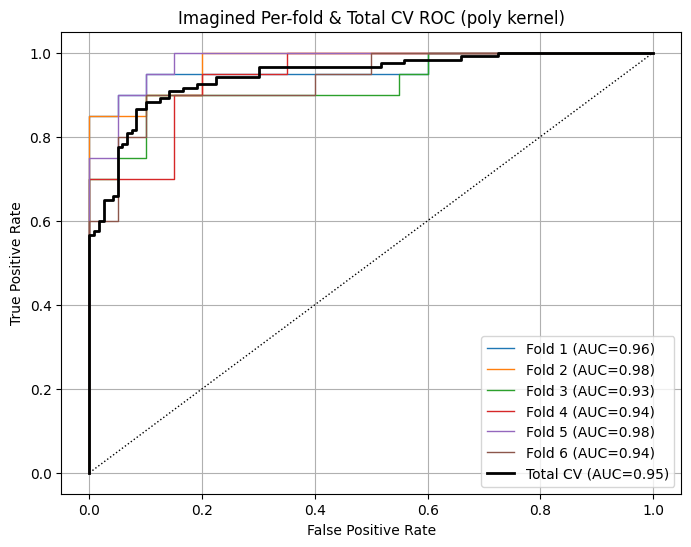

Overall CV accuracy: 0.883


In [174]:
twoLevelCV_withROC(X_img, y_img, datatype='Imagined', kernel = 'poly')

Best params → C=1, degree=4, coef0=1 (inner CV acc=0.900)
Test accuracy: 0.912


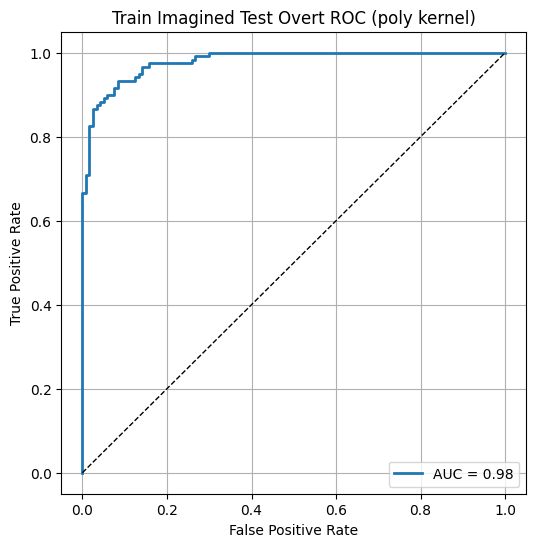

In [152]:
cross_train(X_img, y_img, X_over, y_over, kernel='poly', title="Train Imagined Test Overt")

Best params → C=100, degree=2, coef0=1 (inner CV acc=0.967)
Test accuracy: 0.887


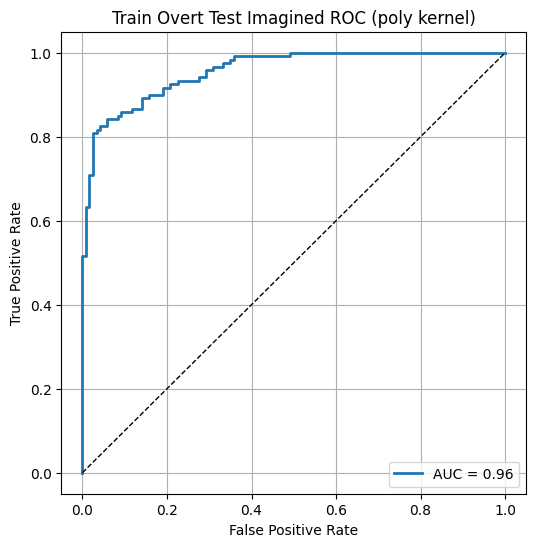

In [153]:
cross_train(X_over, y_over, X_img, y_img, kernel='poly', title="Train Overt Test Imagined")

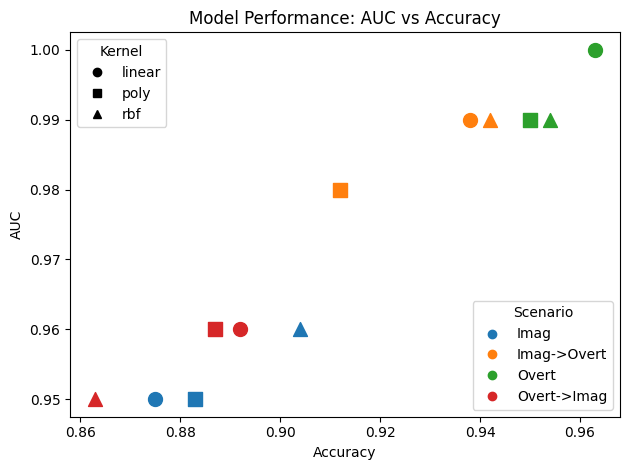

In [177]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_accuracy_auc(results):
    """
    Plots Accuracy vs. AUC for different kernels and training scenarios.

    Parameters:
    - results: list of lists, each entry [kernel (str), scenario (str), accuracy (float), auc (float)]
    """
    # Extract unique kernels and scenarios
    kernels = sorted({r[0] for r in results})
    scenarios = sorted({r[1] for r in results})

    # Map kernels to marker styles
    markers = ['o', 's', '^', 'D', 'v', 'p', 'X']
    marker_map = {kernel: markers[i] for i, kernel in enumerate(kernels)}

    # Map scenarios to default color cycle
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color_map = {scenario: colors[i] for i, scenario in enumerate(scenarios)}

    # Create plot
    fig, ax = plt.subplots()
    for kernel, scenario, acc, auc in results:
        ax.scatter(acc, auc,
                   marker=marker_map[kernel],
                   color=color_map[scenario],
                   s=100)

    # Labels and title
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('AUC')
    ax.set_title('Model Performance: AUC vs Accuracy')

    # Legend for kernels (marker shapes)
    kernel_handles = [
        Line2D([0], [0], marker=marker_map[k], color='black',
               linestyle='None', label=k)
        for k in kernels
    ]
    legend1 = ax.legend(handles=kernel_handles, title='Kernel',
                        loc='upper left')
    ax.add_artist(legend1)

    # Legend for scenarios (colors)
    scenario_handles = [
        Line2D([0], [0], marker='o', color=color_map[s],
               linestyle='None', label=s)
        for s in scenarios
    ]
    ax.legend(handles=scenario_handles, title='Scenario',
              loc='lower right')

    plt.tight_layout()
    plt.show()

results = [
    ['linear', 'Overt', 0.963, 1.00],
    ['linear', 'Imag', 0.875, 0.95],
    ['linear', 'Overt->Imag', 0.892, 0.96],
    ['linear', 'Imag->Overt', 0.938, 0.99],
    ['rbf', 'Overt', 0.954, 0.99],
    ['rbf', 'Imag', 0.904, 0.96],
    ['rbf', 'Overt->Imag', 0.863, 0.95],
    ['rbf', 'Imag->Overt', 0.942, 0.99],
    ['poly', 'Overt', 0.95, 0.99],
    ['poly', 'Imag', 0.883, 0.95],
    ['poly', 'Overt->Imag', 0.887, 0.96],
    ['poly', 'Imag->Overt', 0.912, 0.98],
]
plot_accuracy_auc(results)
